# IRWA Final Project
## **Part 2- Indexing & Evaluation**

Authors:


*   Malena Díaz - u172961
*   Cristina Galvez - u172954






In [1]:
data_path = 'drive/Shareddrives/IRWA/Project/data/tw_hurricane_data.json'
map_path = 'drive/Shareddrives/IRWA/Project/data/tweet_document_ids_map.csv'
tf_idf_path = 'drive/Shareddrives/IRWA/Project/data/tf_idf_results.txt' 
our_rel_asses_path = 'drive/Shareddrives/IRWA/Project/data/rel_assessments_2.csv' 
evaluation_gt_path = 'drive/Shareddrives/IRWA/Project/data/evaluation_gt.csv' 

In [2]:
!pip install word2number

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5582 sha256=01f22fd0881cada1540b67be2aa8c961b5a4e7d591089e50de9bf50fc07b7a28
  Stored in directory: /root/.cache/pip/wheels/4b/c3/77/a5f48aeb0d3efb7cd5ad61cbd3da30bbf9ffc9662b07c9f879
Successfully built word2number


In [3]:
import json
import string
import re
import csv
from word2number import w2n
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import datetime
from array import array
import math
import numpy as np
import time
import collections
from collections import defaultdict
from numpy import linalg as la

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Part 0 - Preprocessing** (part 1 of the project)

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
data_path
with open(data_path) as fp:
    data = fp.readlines()

In [6]:
#importing the map id => document name 
doc_id_dict = {}
with open(map_path) as map_file:
    tsv_reader = csv.reader(map_file, delimiter="\t")
    for line in tsv_reader:
      (doc, id) = line
      doc_id_dict[int(id)] = doc

In [7]:
print("Total number of Tweets in the dataset: {}".format(len(data)))
print("Total number of Tweets in the map: {}".format(len(doc_id_dict)))

Total number of Tweets in the dataset: 4000
Total number of Tweets in the map: 4000


In [8]:
data = [json.loads(x) for x in data] # transform each tweet from string to dictionnary 

In [9]:
def create_struct(data):
  """
  Extract the fields tweet, username, date, hashtag, number of likes, the number of retweets and the tweet url from each tweet. 
  
  Argument:
  data -- An array of tweets (dictionnaries) that contain the keys full_text, user, created_at, entities and retweet_count. User and entities 
  correspond both to dictionnaries containing keys screen_name and favourites_count respectively. 

  Returns:
  collection -- A collection of dictionnaries where the key corresponds to the dictionnary name. Each value is another dictionnary containing the fields 
  of interest. 

  """
  collection = {}     # dictionary of dictionaries

  for tweet in data:
    doc_dict = {}
    id = tweet['id']
    doc_name = doc_id_dict[id]

    doc_dict['id'] = id
    doc_dict['tweet'] = tweet['full_text']
    doc_dict['username'] = tweet['user']['screen_name']
    doc_dict['date'] = datetime.datetime.strptime(tweet['created_at'], '%a %b %d %H:%M:%S %z %Y') #convert to date time 
    doc_dict['hashtag'] = [x['text'] for x in tweet['entities']['hashtags']] #text of te hashtag 
    doc_dict['likes'] = tweet['user']['favourites_count']
    doc_dict['retweet'] = tweet ['retweet_count'] # can also be field retweeted (true)
    doc_dict['url'] = "https://twitter.com/" +  doc_dict['username'] + "/status/" + str(id) #https://twitter.com/[screen name]/status/[Tweet ID]
    collection[doc_name] = doc_dict

  return collection

In [10]:
# to handle turning written numbers into digits

def is_written_num(word):
  # returns True only if it is a written number
  # returns False if it is a digit or something else
  try:
    w2n.word_to_num(word)
    try: 
      int(word)
      return False
    except:
      return True
  except:
    return False

# given an array of strings, takes all written numbers and makes them digits
def make_numbers_digits(text):
  consec_num = False
  num_string = ''
  result = []

  for word in text:
    if not is_written_num(word):
      if consec_num:
        result.append(str(w2n.word_to_num(num_string)))
        consec_num = False
        num_string = ''
      result.append(word)
    else:
      consec_num = True
      num_string += ' ' + word

  if consec_num:
    result.append(str(w2n.word_to_num(num_string)))

  return result

In [11]:
def treat_hashtags(text):
  remove_hashtag = text[1:]
  split_lower_upper = re.sub(r"([A-Z])", r" \1", remove_hashtag)
  return split_lower_upper

In [12]:
def build_terms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    # define stemmer and reference lists
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    whitelist = string.ascii_letters + string.digits + ' '

    # clean text
    line = re.sub(r'http\S+', '', line) # remove urls
    line = re.sub(r'@\S+', '', line) # remove mentioned users
    line = ' '.join([treat_hashtags(i) if i.startswith("#") else i for i in line.split()]) # deal with hashtags
    line = line.replace("-", " ") # deal with dashes
    line = line.replace("$", " dollars") # deal with currencies  
    line = line.replace("€", " euros") # deal with currencies  
    line = ''.join([char if char in whitelist else ' ' for char in line]) # remove all symbols (leave only letters, digits, # and spaces)
    line = line.lower() ## Transform in lowercase
    line = line.split() ## Tokenize the text to get a list of terms
    line = [x for x in line if x not in stop_words]  ##eliminate the stopwords (HINT: use List Comprehension)
    line = [stemmer.stem(x) for x in line ] ## perform stemming (HINT: use List Comprehension)
    line = make_numbers_digits(line) # turn written numbers into digits
    line = [x for x in line if (len(x) > 1 or x.isdigit()) ] # remove single letters

    return line

In [13]:
data = create_struct(data)  # transform data


## **Part 1 - Indexing**

**1. First step: CREATE TF IDF INDEX**

In [14]:
def create_index_tfidf(collection, num_documents):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    collection -- collection of tweets 
    num_documents -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    title_index = defaultdict(str)
    idf = defaultdict(float)

    for key in collection:
        doc = collection[key]
        title_index[key] = doc['id']
        terms = build_terms(doc['tweet']) #retrieves a dict 

        current_page_index = {}

        for position, term in enumerate(terms):
            try:
                current_page_index[term][1].append(position) # term already added in doc array 
            except:
                current_page_index[term]=[key, [position]]

        #normalize term frequencies
        #norm is the square root of the sum of the frequency of each term squared
        norm = 0
        for term, posting in current_page_index.items():
            norm += len(posting[1]) ** 2 #len(posting[1]) == number of times it appears in the doc (frecuency of a term)
        norm = math.sqrt(norm) 

        # compute the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            tf[term].append(np.round(len(posting[1])/norm,4)) #tf is frecuency of the term / norm
            df[term] = df[term] + 1 # df is number of documents where that doc appears (we increment it by one)

        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page) #for each term add this doc and its position to the general index

        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4) #idf of the term is log ( num_docs / df [term])

    return index, tf, df, idf, title_index


In [15]:
start_time = time.time()
num_documents = len(data)
index, tf, df_, idf, title_index = create_index_tfidf(data, num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 202.49 seconds


**2- Second Step: Rank Documents**

In [16]:
def rank_documents(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # for each doc we have a dict where the key is each term of the query term and the value its score
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    query_norm = la.norm(list(query_terms_count.values())) #normalize it 

    for termIndex, term in enumerate(terms):  #for each term in the query 
        if term not in index: #if term is not in index go to the next term 
            continue

        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term]  #tf of the term * idf term 

        # Generate doc_vectors. For each doc & each term we have a score 
        for doc_index, (doc, postings) in enumerate(index[term]): #for each document containing that term 

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs: 
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  #take the tf in that doc and multiply it by the idf 

    #compute cosine similarity between query_vector & the doc_vecotr 
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ] 
    doc_scores.sort(reverse=True)  
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs

In [17]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs =  set()
    first_time = True
    for term in query: #take a list of all documents that contain all the terms
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            # we changed union by intersection so that we get only docs withh all the terms in the query
            if first_time: #first term
                docs = docs.union(set(term_docs))
                first_time = False
            else:
                docs = docs.intersection(set(term_docs))
        except:
            #term is not in index
            pass

    docs = list(docs)
    ranked_docs = rank_documents(query, docs, index, idf, tf, title_index)
    return ranked_docs

In [18]:
queries = [ 'Landfall in South Carolina',
            'Recovery during the hurricane disaster',
            'Floodings in South Carolina',
            'Update on Florida hurricane',
            'Internet out',
            'Tips to be safe',
            'Deaths because of hurricane',
            'Safe roads' ]

In the file TF-IDF_results.txt we store the results for each query. We do this to have a better visualization of the results.

In [19]:
top = 10

with open(tf_idf_path, 'w') as f:
  for i in queries:
    ranked_docs = search_tf_idf(i, index)
    f.write("\n======================\nTop {} results out of {} for the searched query  {}:\n".format(top, len(ranked_docs), i))
    for d_id in ranked_docs[:top]:
        f.write("doc_number= {} - tweet_id: {}\n".format(d_id, title_index[d_id]))
        f.write("tweet: {}\n\n".format(data[d_id]["tweet"]))
f.close()

In [20]:
top = 10
queries_ranked_docs = []
for i in queries:
  queries_ranked_docs.append(search_tf_idf(i, index))

## **Part 2 - Evaluation**

We first create the structure to store the relevance assessments.

In [21]:
import pandas as pd
df = pd.DataFrame(data={'id': range(len(data)),
                        'docs': np.array(data.keys()),
                        'query_1': [0]*len(data),
                        'query_2': [0]*len(data),
                        'query_3': [0]*len(data),
                        'query_4': [0]*len(data),
                        'query_5': [0]*len(data),
                        'query_6': [0]*len(data),
                        'query_7': [0]*len(data),
                        'query_8': [0]*len(data)
                        }
                  )

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       4000 non-null   int64 
 1   docs     4000 non-null   object
 2   query_1  4000 non-null   int64 
 3   query_2  4000 non-null   int64 
 4   query_3  4000 non-null   int64 
 5   query_4  4000 non-null   int64 
 6   query_5  4000 non-null   int64 
 7   query_6  4000 non-null   int64 
 8   query_7  4000 non-null   int64 
 9   query_8  4000 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 312.6+ KB


In [23]:
# importing our relevance assessments
with open(our_rel_asses_path) as eval_file:
    tsv_reader = csv.reader(eval_file, delimiter=";")
    for line in tsv_reader:
      (doc, query, rel) = line
      if doc=="" or query =="" or rel=="":
        break
      df.loc[df['docs'] == doc, [query]] = int(rel)
eval_file.close()

In [24]:
#importing the given relevance assessments
with open(evaluation_gt_path) as eval_file:
    tsv_reader = csv.reader(eval_file, delimiter=",", )
    for line in tsv_reader:
      (doc, query, rel) = line
      if doc == "doc":
        continue
      if doc=="" or query =="" or rel=="":
        break
      query_string = "query_" + str(query)
      df.loc[df['docs'] == doc, [query_string]] = int(rel)
eval_file.close()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       4000 non-null   int64 
 1   docs     4000 non-null   object
 2   query_1  4000 non-null   int64 
 3   query_2  4000 non-null   int64 
 4   query_3  4000 non-null   int64 
 5   query_4  4000 non-null   int64 
 6   query_5  4000 non-null   int64 
 7   query_6  4000 non-null   int64 
 8   query_7  4000 non-null   int64 
 9   query_8  4000 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 312.6+ KB


We assign binary relevance

In [26]:
df['query_1_bin'] = df['query_1'] != 0 
df['query_2_bin'] = df['query_2'] != 0 
df['query_3_bin'] = df['query_3'] != 0 
df['query_4_bin'] = df['query_4'] != 0 
df['query_5_bin'] = df['query_5'] != 0 
df['query_6_bin'] = df['query_6'] != 0 
df['query_7_bin'] = df['query_7'] != 0 
df['query_8_bin'] = df['query_8'] != 0 

In [27]:
df.head()

,id,docs,query_1,query_2,query_3,query_4,query_5,query_6,query_7,query_8,query_1_bin,query_2_bin,query_3_bin,query_4_bin,query_5_bin,query_6_bin,query_7_bin,query_8_bin
0,0,doc_1,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False
1,1,doc_2,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,True
2,2,doc_3,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False
3,3,doc_4,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False
4,4,doc_5,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False


**Precision @K**

In [28]:
def precision_at_k(ranking, rel, query, k=10):
    """
    Parameters
    ----------
    ranking: list of doc_ids ranked by descending order 
    rel: pd dataframe with doc_id and query binary relevance.
    k : number of doc to consider.
    query: the query as a string

    Returns
    -------
    precision @k : float

    """
    
    order =  ranking[:k]
    doc_score = [rel.loc[rel['docs']==i,[query]][query].bool() for i in order] #take relevance of those docs 
    relevant = np.array(doc_score).sum()
    return relevant/k #divide it by k

In [29]:
k=10
print('==== Precision at k=10')
for i in range(len(queries)):
  q = 'query_' + str(i+1) +'_bin'
  print(queries[i], ':', precision_at_k(queries_ranked_docs[i], df[['docs',q]], q, k))

==== Precision at k=10
Landfall in South Carolina : 0.0
Recovery during the hurricane disaster : 0.0
Floodings in South Carolina : 0.3
Update on Florida hurricane : 1.0
Internet out : 0.8
Tips to be safe : 0.8
Deaths because of hurricane : 1.0
Safe roads : 0.9


**Recall @K**

In [30]:
def recall_at_k(ranking, rel, query, k=10):
    """
    Parameters
    ----------
    ranking: list of doc_ids ranked by descending order 
    rel: pd dataframe with doc_id and query binary relevance.
    k : number of doc to consider.
    query: the query as a string

    Returns
    -------
    precision @k : float

    """
    
    order =  ranking[:k]
    doc_score = [rel.loc[rel['docs']==i,[query]][query].bool() for i in order] #take relevance of those docs 
    relevant = np.array(doc_score).sum()
    total_relevant = rel[query].sum()
    return relevant/total_relevant #divide it by total relevant documents

In [31]:
k = 10
print('==== Recall at k=10')
for i in range(len(queries)):
  q = 'query_' + str(i+1) +'_bin'
  print('{} : {:.4f}'.format(queries[i], recall_at_k(queries_ranked_docs[i], df[['docs',q]], q, k)))

==== Recall at k=10
Landfall in South Carolina : 0.0000
Recovery during the hurricane disaster : 0.0000
Floodings in South Carolina : 0.3750
Update on Florida hurricane : 0.4348
Internet out : 0.4000
Tips to be safe : 1.0000
Deaths because of hurricane : 0.3333
Safe roads : 1.0000


**F1  @K**

In [32]:
def f1_score_at_k (ranking, rel, query, k = 10):
    """
    Parameters
    ----------
    ranking: list of doc_ids ranked by descending order 
    rel: pd dataframe with doc_id and query binary relevance.
    k : number of doc to consider.
    query: the query as a string

    Returns
    -------
    average precision @k : float
    """
    p = precision_at_k(ranking, rel, query, k)
    r = recall_at_k(ranking, rel, query, k)

    return ((2*r*p)/(r+p)) #we simply apply the formula

In [33]:
k = 10
print('==== f1 score at k=10')
for i in range(len(queries)):
  q = 'query_' + str(i+1) +'_bin'
  print('{} : {:.4f}'.format(queries[i], f1_score_at_k(queries_ranked_docs[i], df[['docs',q]], q, k)))

==== f1 score at k=10
Landfall in South Carolina : nan
Recovery during the hurricane disaster : nan
Floodings in South Carolina : 0.3333
Update on Florida hurricane : 0.6061
Internet out : 0.5333
Tips to be safe : 0.8889
Deaths because of hurricane : 0.5000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Safe roads : 0.9474


**AVG precision @K**

In [34]:
def avg_precision_at_k(ranking, rel, query, k=10):
    """
    Parameters
    ----------
    ranking: list of doc_ids ranked by descending order 
    rel: pd dataframe with doc_id and query binary relevance.
    k : number of doc to consider.
    query: the query as a string

    Returns
    -------
    average precision @k : float
    """
    gtp = rel[query].sum() #all relevant docs
    order =  ranking[:k]
    doc_score = [rel.loc[rel['docs']==i,[query]][query].bool() for i in order] #take relevance of those docs 
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == True: #only add it when it is relevant 
            n_relevant_at_i +=  1
            prec_at_i +=  n_relevant_at_i/(i+1) # number of relevant documents divided by th position +1 
    return prec_at_i / gtp  #return ap 

In [35]:
k = 10
print('==== Avg precision at k=10')
for i in range(len(queries)):
  q = 'query_' + str(i+1) +'_bin'
  print('{} : {:.4f}'.format(queries[i], avg_precision_at_k(queries_ranked_docs[i], df[['docs',q]], q, k)))

==== Avg precision at k=10
Landfall in South Carolina : 0.0000
Recovery during the hurricane disaster : 0.0000
Floodings in South Carolina : 0.1661
Update on Florida hurricane : 0.4348
Internet out : 0.3242
Tips to be safe : 1.0000
Deaths because of hurricane : 0.3333
Safe roads : 1.0000


**MAP @K**

In [36]:
def map_at_k(queries_ranked_docs, df, queries, k=10):
    """
    Parameters
    ----------
    queries_ranked_docs: array of returned docs of our system ordered by  descending score for each query
    df: data frame containing the doc_id, and for each query (query_id) the binary relevance assessment (true/false) of each doc
    queries: different queries of our system


    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for i in range(len(queries)):  # loop over all query id
        query = 'query_' + str(i+1) + '_bin'
        avp.append(avg_precision_at_k(queries_ranked_docs[i],df[['docs',query]], query, k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp # return mean average precision

In [37]:
k=10
map, avp = map_at_k(queries_ranked_docs,df, queries, k)
print("Map at k = 10: ", map)

Map at k = 10:  0.40730417529330576


**MRR @K**

In [38]:
def rr_at_k(ranking, rel, query, k=10):
    """
    Parameters
    ----------
    ranking: list of doc_ids ranked by descending order 
    rel: pd dataframe with doc_id and query binary relevance.
    k : number of doc to consider.
    query: the query as a string

    Returns
    -------
    Reciprocal Rank for qurrent query
    """
    order =  ranking[:k]
    doc_score = [rel.loc[rel['docs']==i,[query]][query].bool() for i in order] #take relevance of those docs 
    total_relevant = np.array(doc_score).sum()
    if total_relevant == 0:  # if there are no relevant douments return 0
        return 0
    return 1 / (np.argmax(np.array(doc_score == True))+1)  # return position of first doc that is relevant


In [39]:
k = 10
print('==== MRR at k=10')
for i in range(len(queries)):
  q = 'query_' + str(i+1) +'_bin'
  print('{} : {}'.format(queries[i], rr_at_k(queries_ranked_docs[i], df[['docs',q]], q, k)))

==== MRR at k=10
Landfall in South Carolina : 0
Recovery during the hurricane disaster : 0
Floodings in South Carolina : 1.0
Update on Florida hurricane : 1.0
Internet out : 1.0
Tips to be safe : 1.0
Deaths because of hurricane : 1.0
Safe roads : 1.0


**NDCG**

In [40]:
def dcg_at_k(ranking, rel, query, k=10):
    order = ranking[:k] 
    doc_score =  [rel.loc[rel['docs']==i,[query]][query].bool() for i in order] 
    gain = 2** np.array(doc_score) -1  # Compute gain
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator np.arange (3) =[ 0 , 1 , 2 ]
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(ranking, rel, query, k=10):
    sorted_rel = df.sort_values(query, ascending=False)
    ideal_ranking = sorted_rel.head(k)['docs'].tolist() #take k first docs
    dcg_max = dcg_at_k(ideal_ranking, rel,query, k) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(ranking, rel, query, k)/dcg_max, 4) # return ndcg@k

In [41]:
k = 10
print('==== NDCG at k=10')
for i in range(len(queries)):
  q = 'query_' + str(i+1) +'_bin'
  print(queries[i], ':',ndcg_at_k(queries_ranked_docs[i], df[['docs',q]], q, k))

==== NDCG at k=10
Landfall in South Carolina : 0.0
Recovery during the hurricane disaster : 0.0
Floodings in South Carolina : 0.3418
Update on Florida hurricane : 1.0
Internet out : 0.7917
Tips to be safe : 1.0
Deaths because of hurricane : 1.0
Safe roads : 1.0


### Vector Representation
Finally, we have chosen the TF-IDF vector representation.

In [42]:
# get a list of all terms in the collection and sort them alphabetically
terms = list(df_.keys())
terms.sort()

# get the total amount of terms
num_of_terms = len(terms)

# define a dictionary that maps a term to its position in the ordered list
term_to_position = {terms[i] : i for i in range(num_of_terms)}

In [43]:
# make a deep copy of the term frequencies obtained in the indexing function
# important! because we use pop function to retrieve tf scores in order
import copy
tf_2 = copy.deepcopy(tf)

# count time
start_time = time.time()

# define a dictionary to store vectors
vectors = {}

# for each document
for doc in data.keys():

  # define an array of zeros
  vec = [0] * num_of_terms
  terms = build_terms(data[doc]['tweet'])

  # for each term in the document
  for term in set(terms):

    # compute score (tf * idf) and write it in the position
    score = tf_2[term].pop(0) * idf[term]
    vec[term_to_position[term]] = score
  
  # store vector
  vectors[doc] = vec

# get time
print("Total time to create the vectors: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the vectors: 3.16 seconds


Once the TF-IDF vectors have been created we can use the T-SNE algorithm to reduce dimensionallity.

In [44]:
# data transformation for the TSNE model
vector_matrix = [i for i in vectors.values()]
vector_matrix = np.array(vector_matrix)

In [45]:
from sklearn.manifold import TSNE

# fit data into the TSNE model
model = TSNE(n_components=2, verbose=1, random_state=123, perplexity=5)
np.set_printoptions(suppress=True)
z = model.fit_transform(vector_matrix) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.023s...
[t-SNE] Computed neighbors for 4000 samples in 4.227s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 169.495361
[t-SNE] KL divergence after 1000 iterations: 4.820943


In [46]:
# separate documents in different classes (based on whether they were retreived for a specific query)
label = [0] * 4000

q_num = 1

# for each query, if a document was retrieved it will be labeled with the query number
# if it was retrieved by multiple queries, it will be labeled with a 9
# else will be labeled with a 0
for i in queries:
    ranked_docs = search_tf_idf(i, index)
    for doc in ranked_docs:
      doc_num = int(doc[4:])
      if label[doc_num - 1] == 0:
        label[doc_num - 1] = q_num
      else:
        label[doc_num - 1] = 9
    q_num += 1

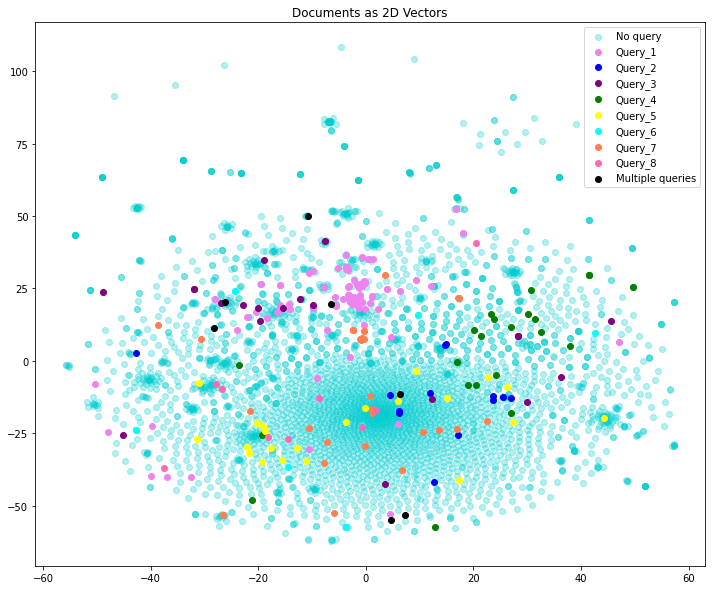

In [47]:
import matplotlib.pyplot as plt

# get coordinates for each document
x = z[:,0]
y = z[:,1]

# define figure
fig, ax = plt.subplots(figsize=(12, 10))

# define dolor, opacity and label name for each class
c = ['darkturquoise', 'violet', 'blue', 'purple', 'green', 'yellow', 'cyan', 'coral', 'hotpink', 'black']
a = [0.3, 1, 1, 1, 1, 1, 1, 1, 1, 1]
l = ['No query'] + ['Query_{}'.format(i) for i in range(1, 9)] + ['Multiple queries']

# scatter plot documents
for n in range(10):
  idx = [i for i in range(4000) if label[i] == n]
  ax.scatter(x[idx], y[idx], c=c[n], alpha=a[n], label=l[n])

ax.legend()
plt.title('Documents as 2D Vectors')

plt.show()